In [3]:
import pandas as pd

df = pd.read_csv("C:\\STUDIA\\Aprendizaje automatico\\FlightDelay_ML_project\\data\\shuffled_preprocessed_flight_data_100k.csv")
display(df.head())

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_dep_delayed,is_arr_delayed
0,2024,4,19,5,2024-04-19,AA,2491.0,STT,"Charlotte Amalie, VI",U.S. Virgin Islands,...,184.0,163.0,1107.0,0,0,0,0,0,False,False
1,2024,5,20,1,2024-05-20,UA,1321.0,EWR,"Newark, NJ",New Jersey,...,189.0,149.0,1085.0,0,0,0,0,0,False,False
2,2024,7,9,2,2024-07-09,WN,3613.0,HOU,"Houston, TX",Texas,...,53.0,38.0,192.0,0,0,0,0,26,True,True
3,2024,9,24,2,2024-09-24,AS,453.0,IAH,"Houston, TX",Texas,...,284.0,252.0,1874.0,0,0,0,0,0,False,False
4,2024,5,31,5,2024-05-31,AA,2847.0,LGA,"New York, NY",New York,...,222.0,185.0,1389.0,0,0,0,0,0,True,True


In [4]:
KPROTOTYPES_FEATURES = [
    "month",
    "day_of_week",
    "dep_time",
    "distance",
    "origin",
    "dest",
    "op_unique_carrier"
    # "arr_delay"
]


import pandas as pd
from typing import List, Tuple
import numpy as np
from pandas.api.types import is_numeric_dtype

def convert_hm_to_minutes(time_val) -> float:
    """
    Converts a time string in 'HH:MM:SS' format (e.g., '22:13:00')
    to total minutes since midnight (e.g., 1333).
    """
    if pd.isna(time_val):
        return np.nan
    try:
        time_str = str(time_val)
        parts = time_str.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return (hours * 60) + minutes
    except (IndexError, ValueError, TypeError):
        return np.nan

def prepare_data(df: pd.DataFrame,
                                 features_list: List[str]
                                 ) -> Tuple[np.ndarray, List[int]]:
    """
    Selects specified features (from a single list) and prepares them for KPrototypes.
    - Dynamically detects numeric vs. categorical columns.
    - Converts 'dep_time' to numeric minutes.
    - Fills NaN (median for numeric, mode for categorical).
    - DOES NOT scale the data.
    - Returns a NumPy matrix and the list of categorical column indices.
    """
    missing = set(features_list) - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in DataFrame: {missing}")

    X = df[features_list].copy()

    if 'dep_time' in features_list:
        X['dep_time'] = X['dep_time'].apply(convert_hm_to_minutes)

    categorical_indices = []

    for i, col in enumerate(features_list):
        if is_numeric_dtype(X[col]):
            median_val = X[col].median()
            X[col] = X[col].fillna(median_val)
            X[col] = X[col].astype(float)
        else:
            mode_val = X[col].mode()
            fill_value = mode_val[0] if not mode_val.empty else "Unknown" # Wartość awaryjna
            X[col] = X[col].fillna(fill_value)
            X[col] = X[col].astype(str)
            categorical_indices.append(i)

    return X.values, categorical_indices




df_delayed = df[df['arr_delay'] > 0].copy()
data_matrix, cat_indices = prepare_data(
        df_delayed,
        features_list=KPROTOTYPES_FEATURES
    )

print(data_matrix.shape)
print(cat_indices)

(36211, 7)
[4, 5, 6]


In [5]:
!pip install kmodes

Running Elbow Method...
Elbow method complete.


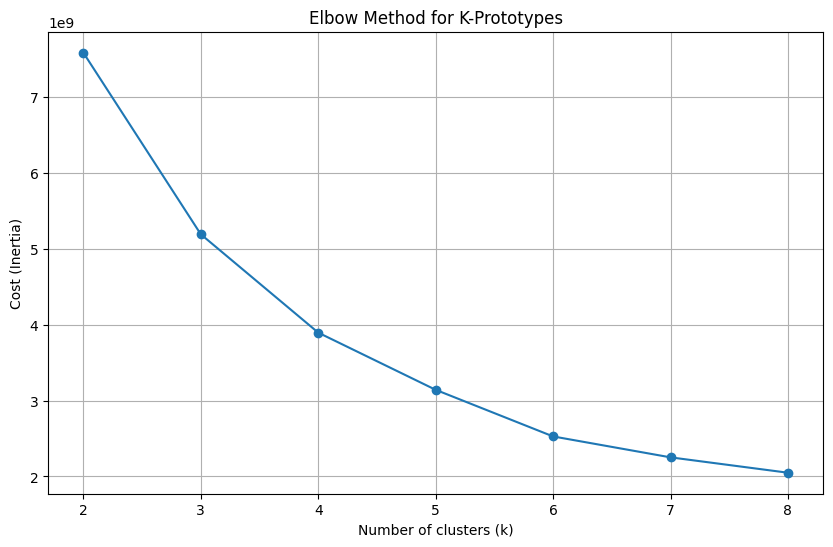

In [6]:
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

k_values = range(2, 9)
costs = []

print("Running Elbow Method...")
for k in k_values:
    kproto_elbow = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    kproto_elbow.fit(data_matrix, categorical=cat_indices)
    costs.append(kproto_elbow.cost_)

print("Elbow method complete.")

plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, marker='o')
plt.title('Elbow Method for K-Prototypes')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [ ]:
from kmodes.kprototypes import KPrototypes

FINAL_K = 5

print(f"Running K-Prototypes with k={FINAL_K}...")
kproto = KPrototypes(n_clusters=FINAL_K, init='Huang', n_init=5, verbose=1, random_state=42)
clusters = kproto.fit_predict(data_matrix, categorical=cat_indices)

print("\n--- CLUSTER CENTROIDS ---")
print("Columns: month, day_of_week, dep_time(min), distance, origin, dest, op_unique_carrier")
print(kproto.cluster_centroids_)

In [8]:
import seaborn as sns

df_delayed['cluster'] = clusters

print("\n--- Cluster sizes---")
print(df_delayed['cluster'].value_counts())

print("\n--- Avergae numerical values in clusters ---")
numeric_cols = ["month", "day_of_week", "distance"]
print(df_delayed.groupby('cluster')[numeric_cols].mean())

print("\n--- The most common numerical value in clusters ---")
categorical_cols = ["origin", "dest", "op_unique_carrier"]
for col in categorical_cols:
    print(f"\n--- The most common '{col}' in clusters ---")
    print(df_delayed.groupby('cluster')[col].apply(lambda x: x.mode()[0]))


--- Cluster sizes---
cluster
0    10610
4     9144
2     8740
1     5174
3     2543
Name: count, dtype: int64

--- Avergae numerical values in clusters ---
            month  day_of_week     distance
cluster                                    
0        6.474081     4.073044   382.594062
1        6.428102     4.041940  1463.747391
2        6.374714     4.091876   945.386156
3        6.418797     4.016123  2385.624459
4        6.442257     4.006890   535.398075

--- The most common numerical value in clusters ---

--- The most common 'origin' in clusters ---
cluster
0    CLT
1    DFW
2    DFW
3    LAX
4    ATL
Name: origin, dtype: object

--- The most common 'dest' in clusters ---
cluster
0    CLT
1    DFW
2    DFW
3    LAX
4    ATL
Name: dest, dtype: object

--- The most common 'op_unique_carrier' in clusters ---
cluster
0    WN
1    WN
2    WN
3    DL
4    WN
Name: op_unique_carrier, dtype: object


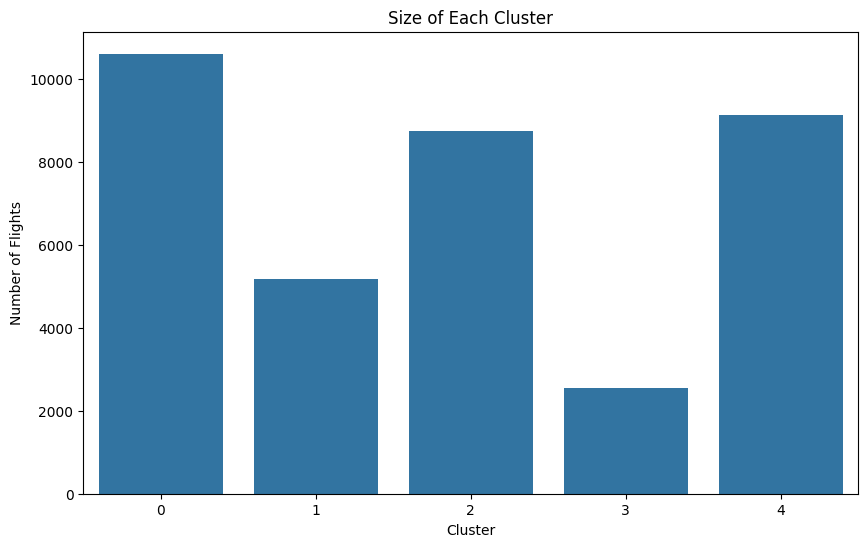

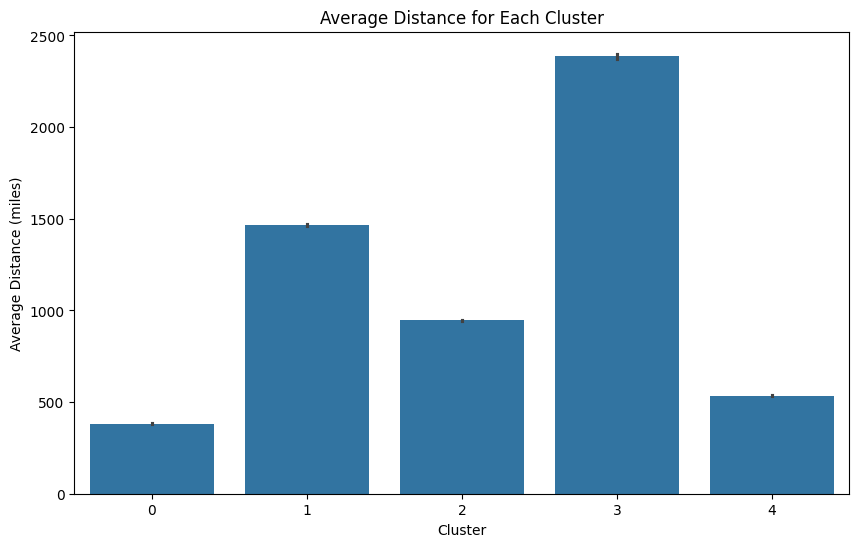

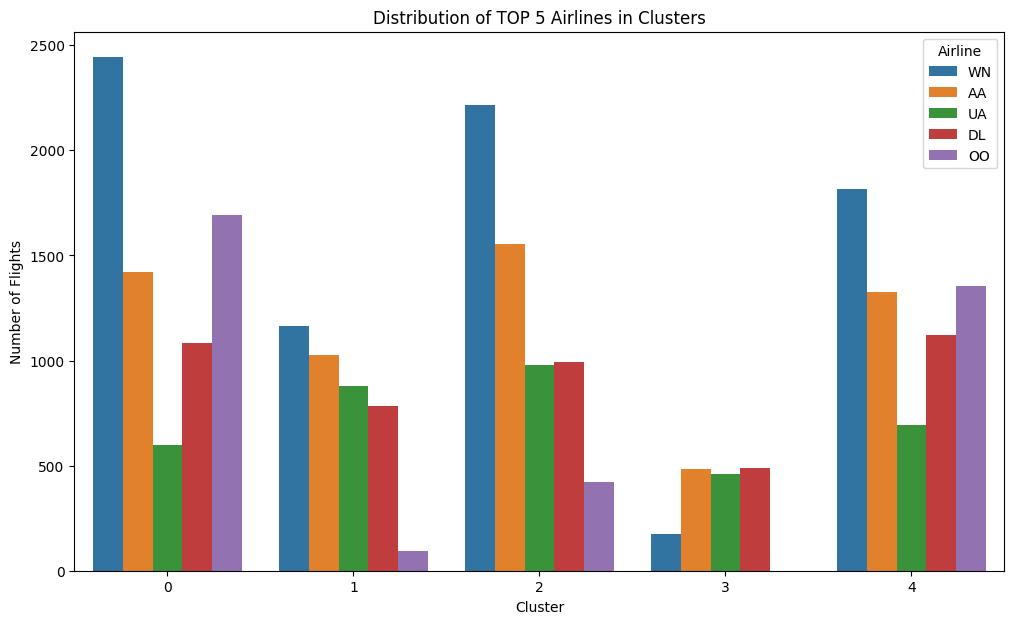


Plotting PCA graph...


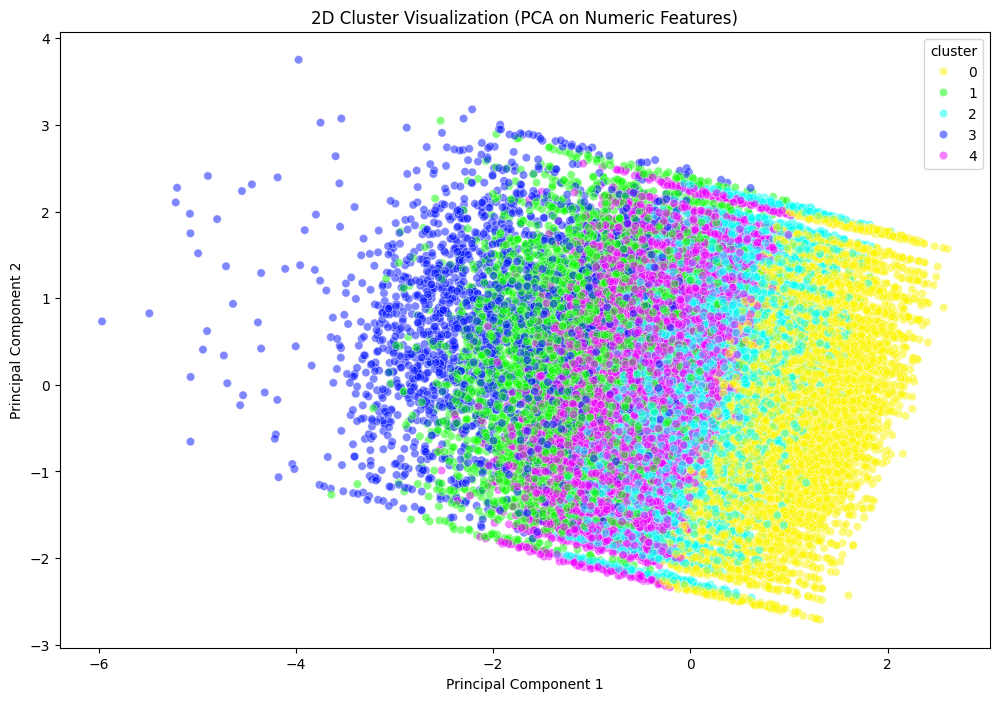

In [9]:
# --- Cluster Sizes ---
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_delayed)
plt.title('Size of Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Flights')
plt.show()

# --- Average Distance in Clusters ---
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='distance', data=df_delayed, estimator=np.mean)
plt.title('Average Distance for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Distance (miles)')
plt.show()

# --- Distribution of Airlines (Top 5) in Each Cluster ---
top_carriers = df_delayed['op_unique_carrier'].value_counts().index[:5]
df_top_carriers = df_delayed[df_delayed['op_unique_carrier'].isin(top_carriers)]

plt.figure(figsize=(12, 7))
sns.countplot(x='cluster', hue='op_unique_carrier', data=df_top_carriers)
plt.title('Distribution of TOP 5 Airlines in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Flights')
plt.legend(title='Airline')
plt.show()

# --- PCA Visualization (On Numeric Features Only) ---
# It ignores 'origin', 'dest', etc., but gives a general overview.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

numeric_data = data_matrix[:, :cat_indices[0]]

scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(numeric_data_scaled)

pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['cluster'] = clusters

print("\nPlotting PCA graph...")
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="cluster",
    palette=sns.color_palette("hsv", FINAL_K),
    data=pca_df,
    legend="full",
    alpha=0.5
)
plt.title('2D Cluster Visualization (PCA on Numeric Features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

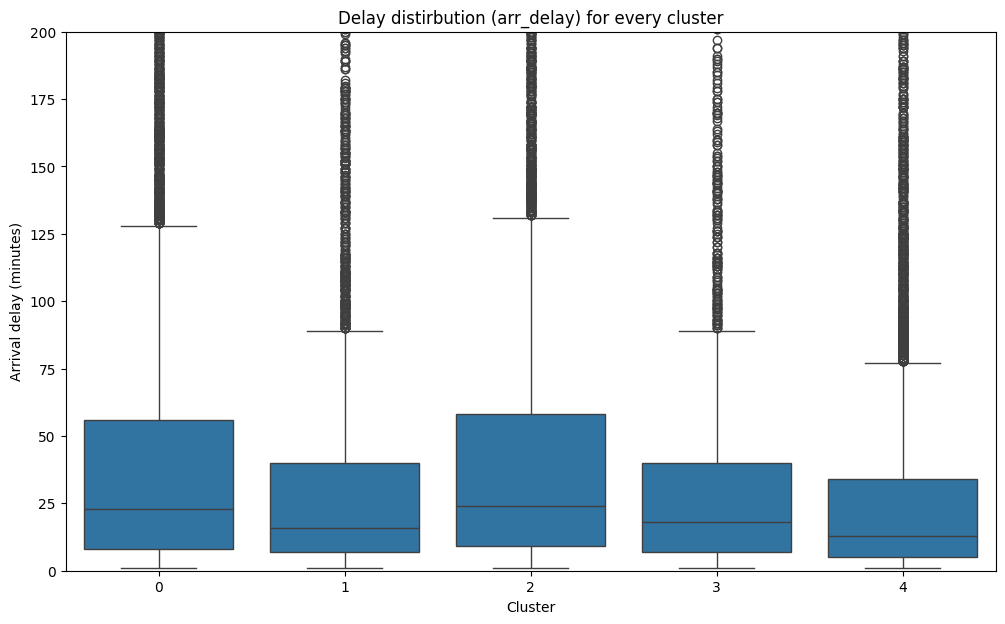

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.boxplot(x='cluster', y='arr_delay', data=df_delayed)
plt.title('Delay distirbution (arr_delay) for every cluster')
plt.xlabel('Cluster')
plt.ylabel('Arrival delay (minutes)')
plt.ylim(0, 200)
plt.show()

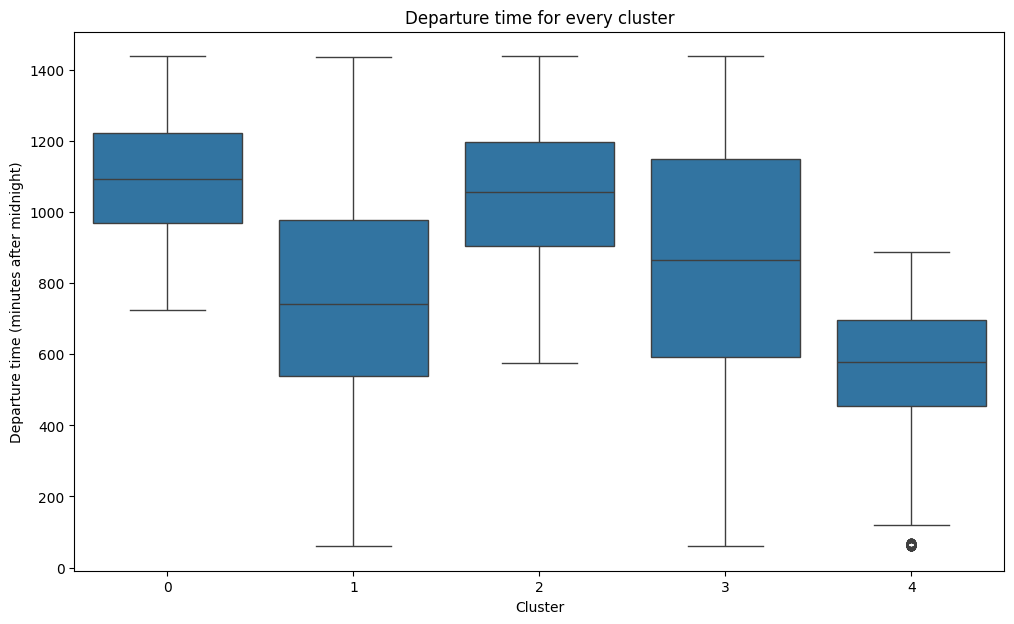

In [11]:
df_delayed['dep_time_min'] = df_delayed['dep_time'].apply(convert_hm_to_minutes)

plt.figure(figsize=(12, 7))
sns.boxplot(x='cluster', y='dep_time_min', data=df_delayed)
plt.title('Departure time for every cluster')
plt.xlabel('Cluster')
plt.ylabel('Departure time (minutes after midnight)')
plt.show()


--- Average delay minutes by reason and cluster ---
         carrier_delay  weather_delay  nas_delay  security_delay  \
cluster                                                            
0            13.067672       2.685391   7.701037        0.110085   
1            14.927136       1.548319   7.266911        0.050058   
2            12.813959       2.348741   8.794394        0.083867   
3            14.517106       1.243020   7.974833        0.117971   
4            15.032480       2.154199   6.021982        0.037948   

         late_aircraft_delay  
cluster                       
0                  20.801414  
1                  13.597217  
2                  21.755835  
3                  12.764845  
4                   9.367563  

--- Percentage share of delay reasons ---
         carrier_delay  weather_delay  nas_delay  security_delay  \
cluster                                                            
0             0.294545       0.060529   0.173581        0.002481   
1     

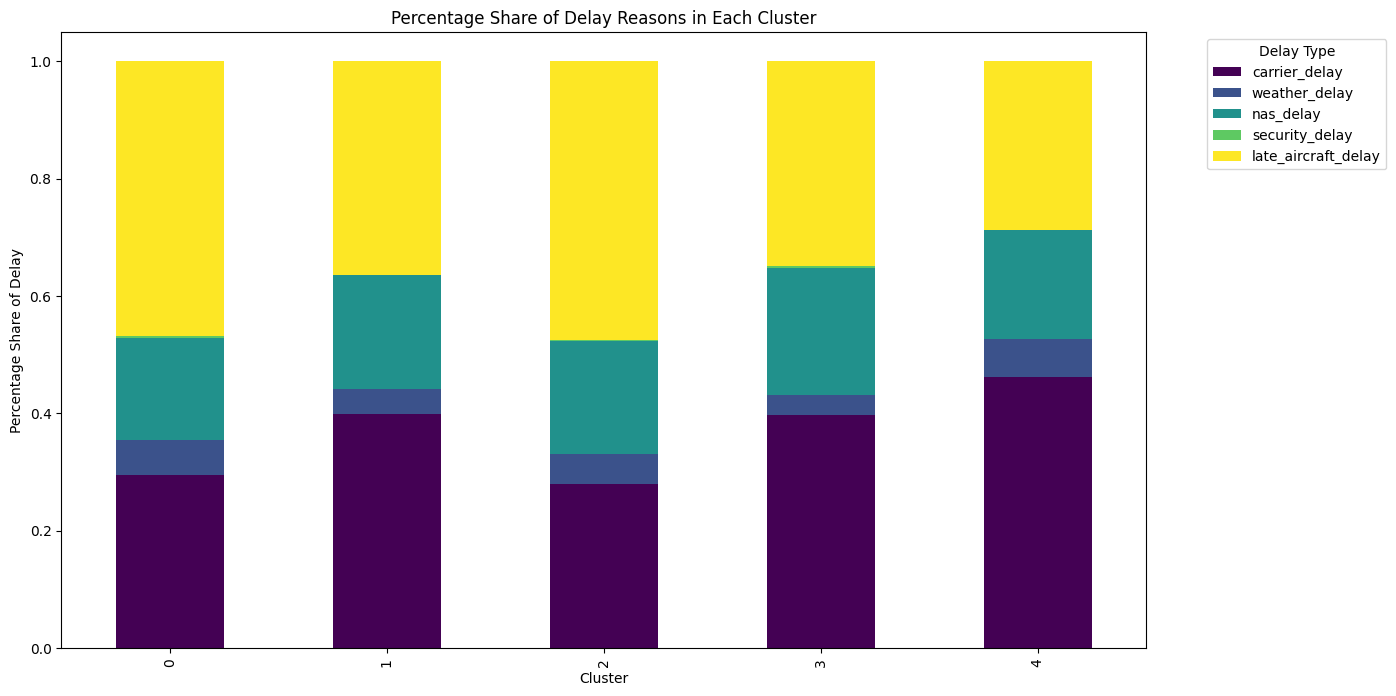

In [12]:
delay_reason_cols = [
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'late_aircraft_delay'
]

cluster_delay_means = df_delayed.groupby('cluster')[delay_reason_cols].mean()

print("\n--- Average delay minutes by reason and cluster ---")
print(cluster_delay_means)

# --- Visualization: Percentage share of delay reasons (Stacked Bar Chart) ---

cluster_delay_sums = df_delayed.groupby('cluster')[delay_reason_cols].sum()

cluster_delay_perc = cluster_delay_sums.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Percentage share of delay reasons ---")
print(cluster_delay_perc)
cluster_delay_perc.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    colormap='viridis'
)
plt.title('Percentage Share of Delay Reasons in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage Share of Delay')
plt.legend(title='Delay Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import numpy as np

numeric_indices = [i for i in range(data_matrix.shape[1]) if i not in cat_indices]

numeric_data_unscaled = data_matrix[:, numeric_indices].astype(float)

scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data_unscaled)

print(f"--- Metrics for k = {FINAL_K} ---")

if FINAL_K > 1:

    # --- 1. Silhouette Coefficient ---
    try:
        silhouette_avg = silhouette_score(numeric_data_scaled, clusters, random_state=42)
        print(f"Silhouette Coefficient: {silhouette_avg:.4f}")
    except ValueError as e:
        print(f"Can't calculate Silhouette Score: {e}")

    # --- 2. Calinski-Harabasz Index ---
    try:
        ch_score = calinski_harabasz_score(numeric_data_scaled, clusters)
        print(f"Calinski-Harabasz Index: {ch_score:.4f}")
    except ValueError as e:
        print(f"NCan't calculate Calinski-Harabasz: {e}")

    # --- 3. Davies-Bouldin Index ---
    try:
        db_score = davies_bouldin_score(numeric_data_scaled, clusters)
        print(f"Davies-Bouldin Index: {db_score:.4f}")
    except ValueError as e:
        print(f"Can't calculateć Davies-Bouldin: {e}")


--- Metrics for k = 5 ---
Silhouette Coefficient: 0.1064
Calinski-Harabasz Index: 4875.1407
Davies-Bouldin Index: 2.5436
